In [81]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./Project_3.csv
./Project_3.ipynb
./.ipynb_checkpoints/Project_3-checkpoint.ipynb
./.ipynb_checkpoints/Project_3-checkpoint.csv
./data/hello
./data/.ipynb_checkpoints/hello-checkpoint


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Assignment: As a customer I would like to be able to assist my sales team to target the correct customer market. Given the data emailed to you provide Insight into what you see. Then Create a ML model that would allow for a Prediction of Whether a Cog would be Purchased by the given customer.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The data was provided to us via csv file.

In [82]:
import pandas as pd

In [83]:
df = pd.read_csv("Project_3.csv")

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [84]:
df_dropped = df.drop(columns=["name"])

In [105]:
# if the item is less than 0, append the abs value to new column and set old "Purchased" value to 0

df_dummies = pd.get_dummies(df_dropped["Purchased"], dtype=int)
df_one_hot = pd.concat([df_dropped, df_dummies], axis=1)
df_one_hot = df_one_hot.rename(columns={-1: "Returned", 0: "Not Bought", 1: "Bought"})
df_one_hot.head()

,User ID,Gender,Age,EstimatedSalary,Purchased,Returned,Not Bought,Bought
0,10000,Male,23,122492,1,0,0,1
1,10001,Female,47,142543,0,0,1,0
2,10002,Female,54,70131,1,0,0,1
3,10003,Male,20,108437,0,0,1,0
4,10004,Male,57,100832,1,0,0,1


In [106]:
import matplotlib.pyplot as plt

In [107]:
df_no_dupes = df_one_hot.drop_duplicates()
print(len(df_one_hot), len(df_no_dupes))

1001 1001


In [114]:
df_no_dupes = df_no_dupes.drop(columns="Purchased")

<BarContainer object of 1001 artists>

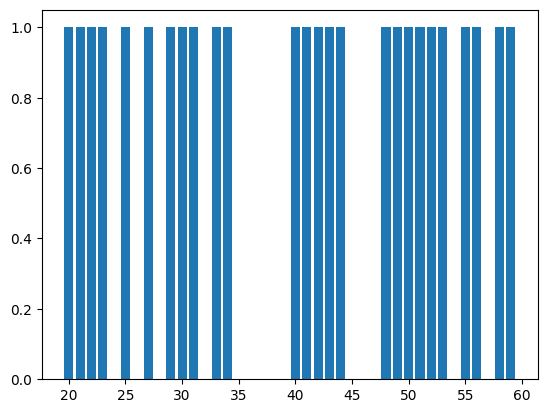

In [115]:
df_sort_age = df_no_dupes.sort_values(by="Age")
plt.bar(df_sort_age["Age"], df_sort_age["Returned"])

Older people did NOT return products more as they got 

In [116]:
import numpy as np

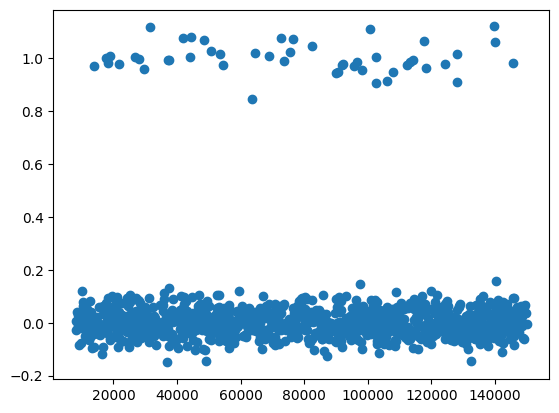

In [117]:
jitter = np.random.normal(0, 0.05, len(df_no_dupes))
price_jit = df_sort_age["Returned"] + jitter
plt.scatter(df_sort_age["EstimatedSalary"], price_jit)

In [152]:
df_gender_dummies = pd.get_dummies(df_no_dupes["Gender"], dtype=int)
df_one_hot = pd.concat([df_no_dupes, df_gender_dummies], axis=1)
df_one_hot = df_one_hot.drop(columns=["Gender", "Female"])
df_one_hot = df_one_hot.rename(columns={"Male": "Is_male"})

In [153]:
df_one_hot.head()

,User ID,Age,EstimatedSalary,Returned,Not Bought,Bought,Is_male
0,10000,23,122492,0,0,1,1
1,10001,47,142543,0,1,0,0
2,10002,54,70131,0,0,1,0
3,10003,20,108437,0,1,0,1
4,10004,57,100832,0,0,1,1


In [160]:
correlation_matrix = df_one_hot.corr()
correlation_matrix = correlation_matrix["Bought"].sort_values(ascending=False)
print(correlation_matrix)

Bought             1.000000
User ID            0.049337
EstimatedSalary    0.012867
Cluster           -0.000694
Is_male           -0.034637
Age               -0.118995
Returned          -0.204200
Not Bought        -0.906387
Name: Bought, dtype: float64


In [161]:
from sklearn.cluster import KMeans

In [162]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [163]:
df_scaled = scaler.fit_transform(df_one_hot)

In [174]:
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(df_scaled)
print(labels)

[0 1 0 ... 4 4 4]


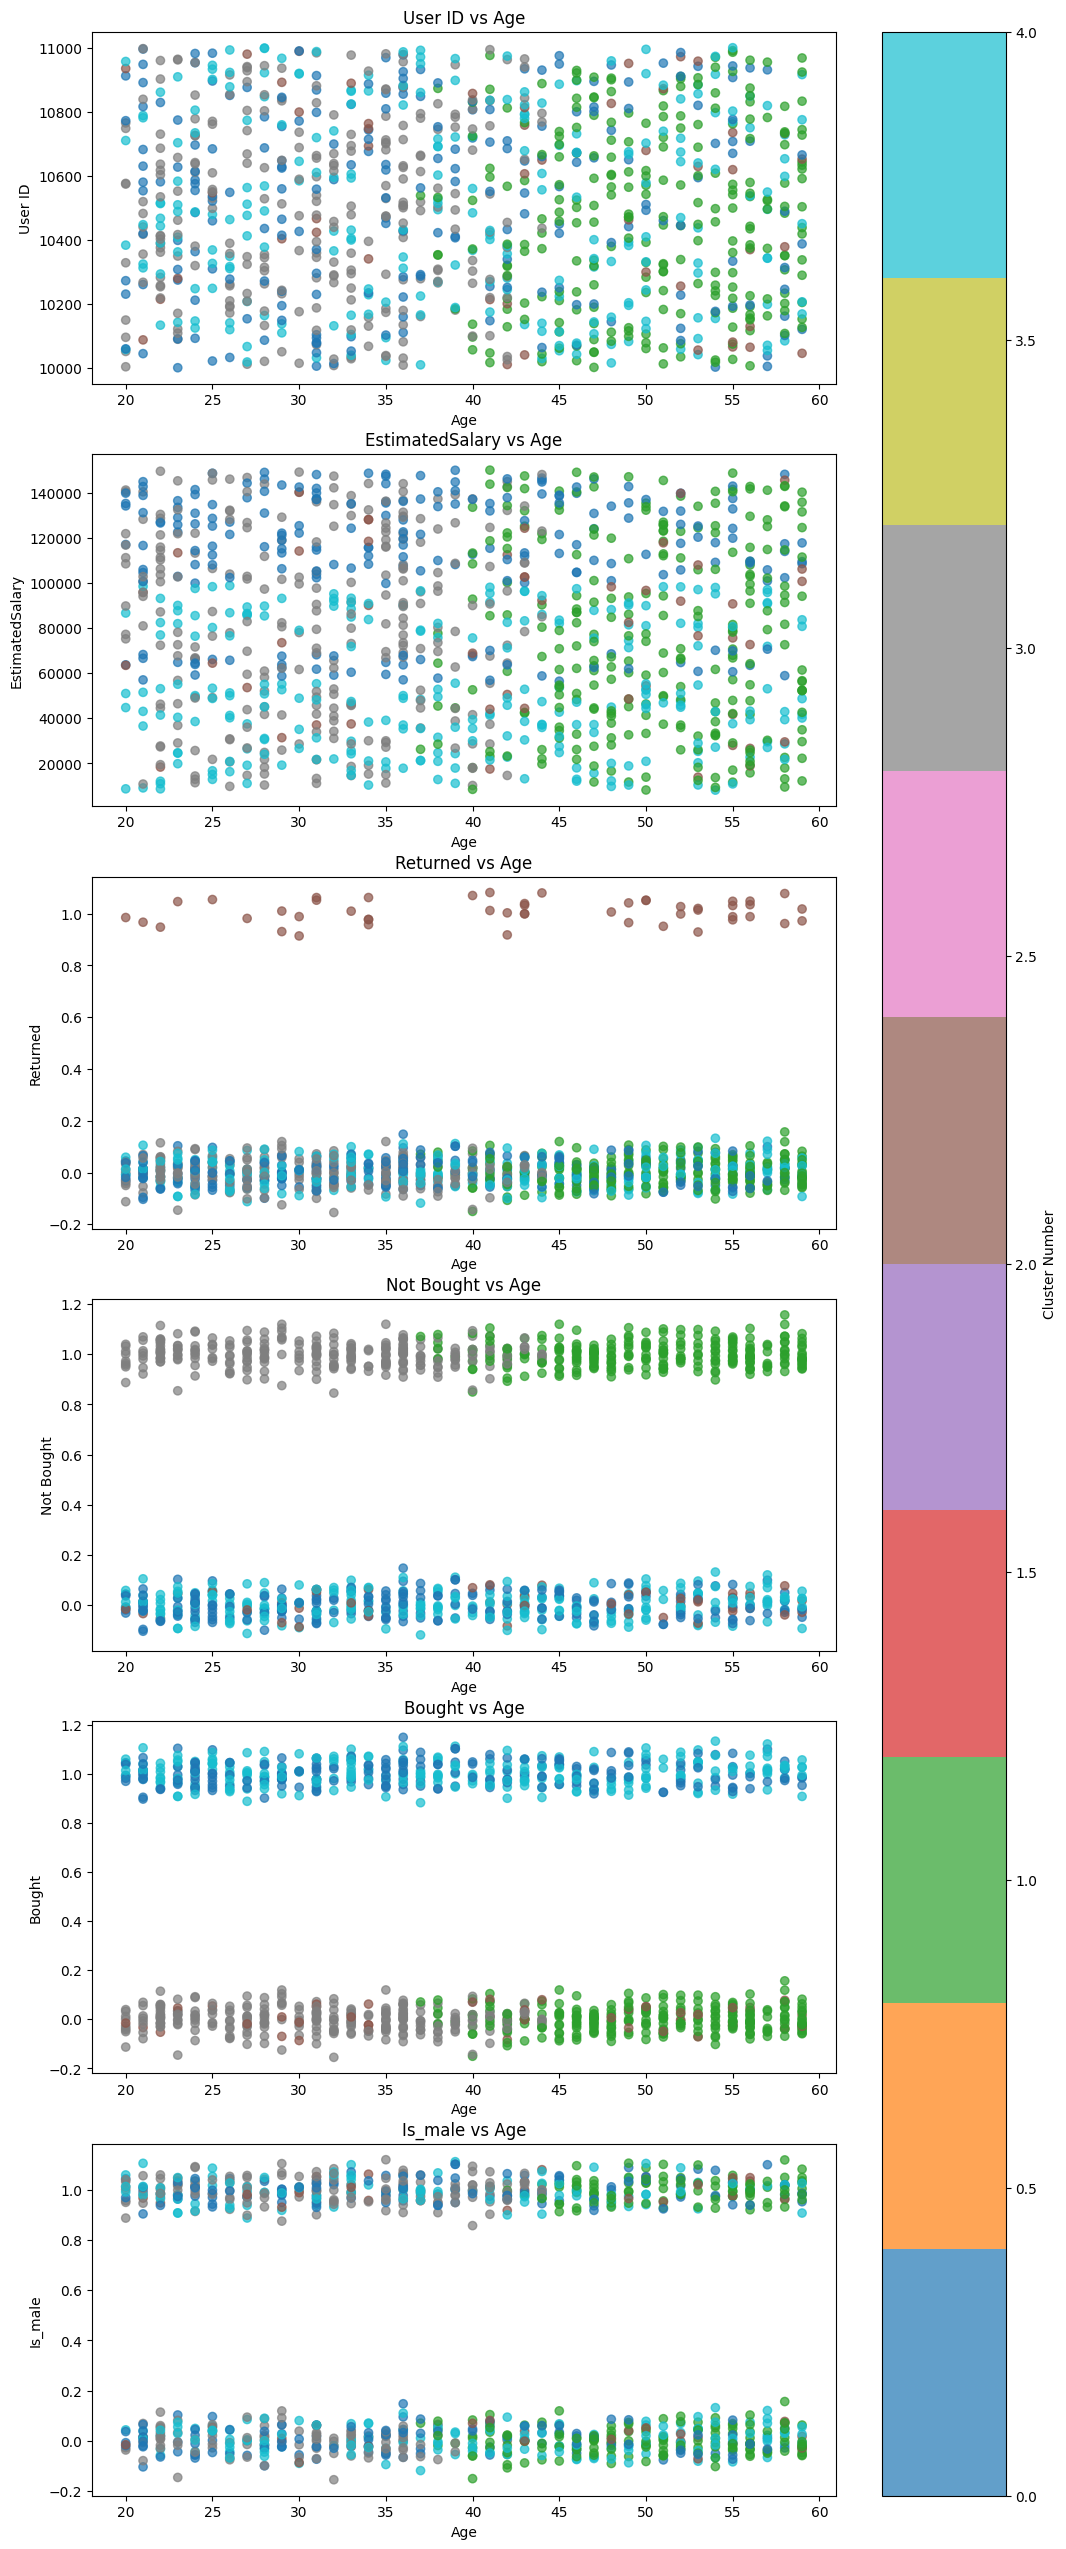

In [175]:
df_one_hot["Cluster"] = labels

x_feature = "Age"
features = [col for col in df_one_hot.columns if col not in [x_feature, "Cluster"]]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 32))

if len(features) == 1:
    axes = [axes]

for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        df_one_hot[x_feature],
        df_one_hot[feature] + jitter,
        c=df_one_hot["Cluster"],
        cmap="tab10",
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {x_feature}")

fig.colorbar(scatter, ax=axes, label="Cluster Number")
plt.show()

Everyone who returned stuff is in cluster 6. Not sure if this is a patten or its just clustering based on returns

In [176]:
df_one_hot.to_csv("clustered_data.csv")

In [177]:
df_clustered = pd.read_csv("clustered_data.csv")
df_clustered.drop(df_clustered.columns[df_clustered.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

In [178]:
cluster_means = df_clustered.groupby("Cluster").mean(numeric_only=True)
print(cluster_means)

              User ID        Age  EstimatedSalary  Returned  Not Bought  \
Cluster                                                                   
0        10530.433333  37.100000    112152.680952       0.0         0.0   
1        10468.759036  50.305221     76563.578313       0.0         1.0   
2        10535.775510  42.673469     76575.632653       1.0         0.0   
3        10495.803922  31.035294     81952.592157       0.0         1.0   
4        10502.962185  38.777311     51848.168067       0.0         0.0   

         Bought   Is_male  
Cluster                    
0           1.0  0.490476  
1           0.0  0.389558  
2           0.0  0.530612  
3           0.0  0.600000  
4           1.0  0.441176  


I think the most unique attribute is the returned one. There aren't a lot of people who did return the cog, but I can't really see a trend right now. 

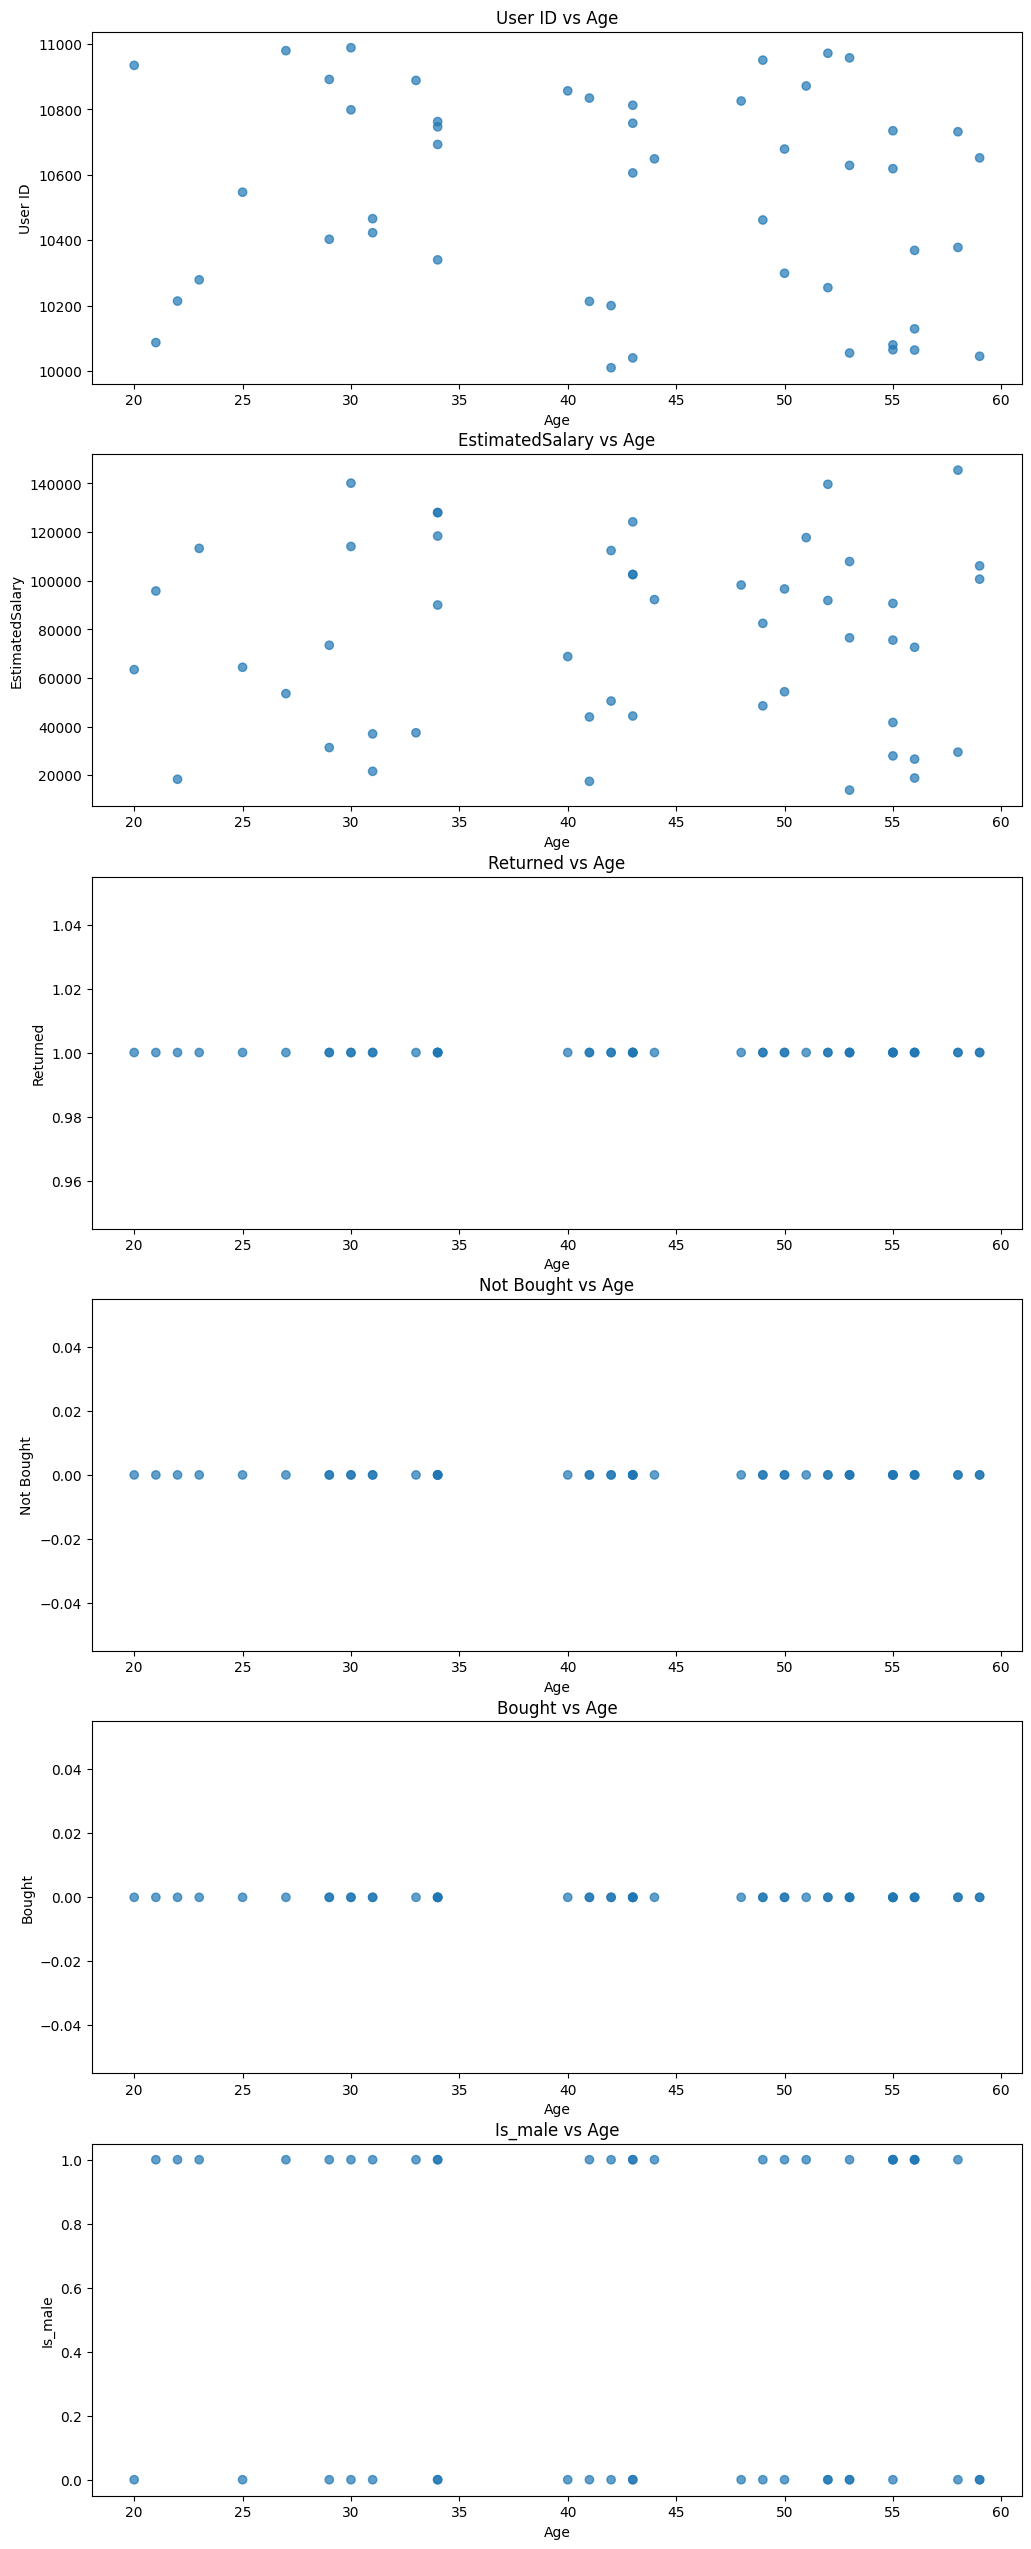

In [184]:
df_returned = df_clustered[df_clustered["Cluster"] == 2]

x_feature = "Age"
features = [col for col in df_returned.columns if col not in [x_feature, "Cluster"]]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 32))

if len(features) == 1:
    axes = [axes]
    
jitter_returned = np.random.normal(0, 0.01, len(df_returned))
for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        df_returned[x_feature],
        df_returned[feature],
        c=df_returned["Cluster"],
        cmap="tab10",
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {x_feature}")

Unfortunately I still don't know what's going on. The only thing I have been to find it the fact that both men and women returned this product around a big age, like multiples of 5 (25, 30, 35, etc.) This seems unimportant, however.

# 4.Prepare the Data


Apply any data transformations and explain what and why


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
def infrence(prams):
    results = m.run(prams)
    return results 